In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import vtk
import scipy.stats
from scipy import interpolate
from vtk.util import numpy_support as npvtk
import json
import shutil
import pymesh
import meshio

In [14]:
def inter_curve_2d(points,line_res, method = 'cubic'):
    distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2,axis=1)))
    distance = np.insert(distance, 0, 0)/distance[-1]
    alpha = np.linspace(0,1,line_res+1)
    from scipy.interpolate import interp1d
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    return interpolator(alpha)

In [23]:
# orignal curve
x1 = 1/np.flip(np.arange(100)+1)
y1 = np.sin(x1*np.pi)

#interpolation 
x2 = np.linspace(0,1,1001)

y2 = inter_curve_2d(np.concatenate((x1,y1)).reshape(2, -1).T, 100)

In [24]:
y2.shape

(101, 2)

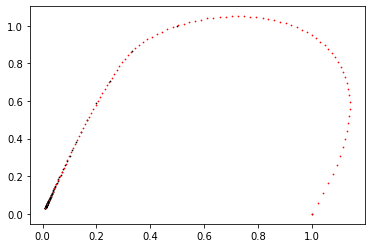

In [25]:
plt.scatter(x1,y1, color = 'k', s = 0.5)
plt.scatter(y2[:,0],y2[:,1], color = 'r', s = 0.5)

In [60]:
xx= np.linspace(0,1,6)
yy= np.linspace(-1,1,6)
X, Y = np.meshgrid(xx,yy)


In [50]:
grid.shape

(2, 36)

(-1.5, 1.5)

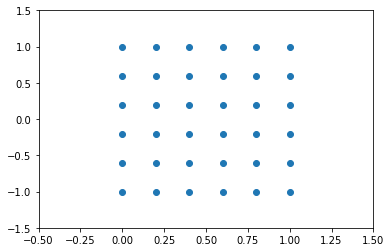

In [49]:
plt.scatter(grid[0][:],grid[1][:])
plt.xlim([0-0.5,1+0.5])
plt.ylim([-1-0.5,1+0.5])

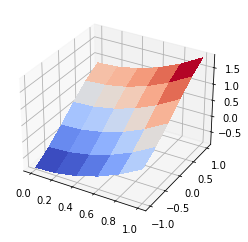

In [61]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
z = X**2+ np.sin(Y)
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [56]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

In [58]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)
X,Y = np.meshgrid(x,y)
Z = X*np.exp(-X**2 - Y**2)



In [59]:
X.shape

(100, 100)

In [261]:
# testing loop class:
points = np.array([[0, 1, 8, 2, 2],
                   [1, 0, 6, 7, 2]]).T  # a (nbre_points x nbre_dim) array
my_loop = loop(points, np.array([1,3]), ['a','b'], np.array([100,100]))
my_loop.interpolation()

In [1]:
# # my_loop.pts[my_loop.segs]
# aa = np.array([0,3,8,10])-9>0
# print(np.append(np.arange(10),10))
# print(np.array([0,3,8,10]))
# # aa*1
# np.where((np.diff(aa))>0)[0]

# np.append(np.arange(10),1)
# ['patch']*3

In [73]:
class loop:
    # inner loop is counterclockwise, outer loop is clockwise
    # interpolation methods include: ['slinear', 'quadratic', 'cubic']
    # resolutions means # of segements between two knot points 
    def __init__(self, points, segments, labels, resolutions, scale = 1):
        self.pts = points*scale
        self.n_pts = len(self.pts)
        self.pts_loop = np.append(points,points[0][None,...],axis = 0)
        self.segs = segments-1
        self.segs_loop = np.append(self.segs,self.n_pts)
        
        # print(self.segs, self.segs_loop)
        self.con = self.loop_con_gen(self.n_pts)
        self.labels = labels
        self.res = resolutions
    def loop_con_gen(self, n):
            return np.hstack((np.arange(n)[...,None],np.mod(np.arange(n)+1,n)[...,None]))
    def inter_curve_2d(self, points,line_res, method ):
        distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2,axis=1)))
        distance = np.insert(distance, 0, 0)/distance[-1]
        alpha = np.linspace(0,1,line_res+1)
        from scipy.interpolate import interp1d
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        return interpolator(alpha)
    
    def interpolation(self, interp_method = 'slinear'): 
        new_points = []
        for i in range(len(self.segs)):
            # print('loop', i)
            # print('index', self.segs_loop[i],self.segs_loop[i+1])
            # print(self.pts_loop[self.segs_loop[i]:self.segs_loop[i+1]+1])
            temp = self.inter_curve_2d(self.pts_loop[self.segs_loop[i]:self.segs_loop[i+1]+1],self.res[i],method = interp_method)
            new_points.append(temp[:-1])
        new_points = np.vstack(new_points)
        new_segments = np.insert(np.cumsum(self.res[:-1]),0,0)
        
        # update loop info
        self.pts = new_points
        self.n_pts = len(self.pts)
        self.con = self.loop_con_gen(self.n_pts)
        self.segs = np.insert(np.cumsum(self.res)[:-1],0,0)

class mesher_2d:
    def __init__(self, points, segments, labels, resolutions, scale = 1):
        self.n_iloop=0
        self.outline = loop(points, segments, labels, resolutions)
        self.outline.interpolation()
        self.pts = self.outline.pts
        self.n_pts = self.outline.n_pts
        self.n_pts_offsets = [0,self.n_pts]
        self.segs = [self.outline.segs]
        self.con_list=[self.outline.con]
        self.con = np.array(self.con_list)
        self.labels = [labels]
        self.seed = []
        
    def add_inner_loop(self, points, segments, labels, resolutions, seed=0, scale = 1):
        if seed ==0:
            seed = np.average(points,axis = 0)
        self.n_iloop +=1
        temp_loop = loop( points, segments, labels, resolutions)
        temp_loop.interpolation()
        # self.segs_no_offset.append(temp_loop.segs)
        self.segs.append(temp_loop.segs+self.n_pts)
        self.labels.append(temp_loop.labels)
        self.con_list.append(temp_loop.con+self.n_pts)
        self.con = np.vstack(self.con_list)
        self.pts = np.vstack((self.pts,temp_loop.pts))
        self.n_pts += temp_loop.n_pts
        self.n_pts_offsets.append(self.n_pts)
        self.seed.append(seed)
    def meshing(self, min_angle=None, conforming_delaunay= False, max_area = 0.05, split_boundary = False,verbosity = 0):
        #available formats: openfoam, su2, vtp, msh
        # load in info 
        tri = pymesh.triangle()
        tri.points = self.pts
        tri.segments = self.con # segments in pymesh means con(connectivity)
        tri.holes = np.array(self.seed)
        tri.max_area = max_area;
        tri.split_boundary = split_boundary;
        tri.verbosity = verbosity;
        tri.conforming_delaunay= conforming_delaunay
        if min_angle!=None:
            tri.min_angle = min_angle
        tri.run()
        self.mesh = tri.mesh
        
        # find out the new bd loop bc
        bc_segs = []
        bc_labels = []
        bc_lines = []
        
        tri_loop_index = np.zeros(self.n_iloop+1,dtype = int)
        
        for i in range(self.n_iloop+1):
            pick_pt = np.min(self.mesh.boundary_loops[i])
            find=np.append(self.n_pts_offsets,self.n_pts)-pick_pt>0
            
            # print(np.append(self.n_pts_offsets,self.n_pts),pick_pt )
            ii = int(np.where(np.diff(find*1))[0])
            tri_loop_index[ii] = i
            
        for i in range(self.n_iloop+1):
            ii = tri_loop_index[i]
            # print('step',i)
            # print(self.n_pts_offsets[i])
            # print(self.mesh.boundary_loops[tri_loop_index[i]])
            break_head = np.where(self.mesh.boundary_loops[ii]==self.n_pts_offsets[i])[0]
            if break_head == []:
                print('error: cant find header in the bc loop')
            # print(break_head,self.mesh.boundary_loops[ii].shape)
            loop_reheaded = self.rehead(self.mesh.boundary_loops[ii], break_head)
            loop_reheaded_closed = np.append(loop_reheaded,loop_reheaded[0])
            segs_index = np.zeros(len(self.segs[i]),int)
            for j in range(len(self.segs[i])):
                # print(j,self.segs[i][j] )
                
                segs_index[j] = np.where(loop_reheaded==self.segs[i][j])[0]
            segs_index_closed = np.append(segs_index,len(loop_reheaded))
            # seg_closed = np.append(self.segs[i],self.n_pts_offsets[i+1])
            # print(segs_index_closed)
            
            for j in range(len(self.segs[i])):
                current_seg = loop_reheaded_closed[segs_index_closed[j]:segs_index_closed[j+1]+1]
                bc_segs.append(current_seg)
                bc_labels.append(self.labels[i][j])
                bc_lines.append(np.vstack((current_seg[:-1],current_seg[1:])).T)
                
        self.mesh_bc_segs = bc_segs
        self.mesh_bc_labels = bc_labels
        self.mesh_bc_lines = bc_lines
    
        # summary 
            #creat summary for vtk and vtp file. summary is long, short is to save to json file
        surf_points = self.mesh.nodes.copy()
        surf_connection = self.mesh.elements.copy()
        cell_summary_2d = []
        cell_summary_2d_short = []
        cell_summary_2d.append([5,3,len(surf_connection),surf_connection,'interior','triangle'])
        cell_summary_2d_short.append([5,3,len(surf_connection),'interior','triangle'])
        for i in range(len(self.mesh_bc_labels)):
            cell_summary_2d.append([3,2,len(self.mesh_bc_lines[i]),self.mesh_bc_lines[i],self.mesh_bc_labels[i],'line'])
            cell_summary_2d_short.append([3,2,len(self.mesh_bc_lines[i]),self.mesh_bc_labels[i],'line'])
        cell_summary_2d.append([0,1,len(surf_points),surf_points,'points','vertex'])
        cell_summary_2d_short.append([0,1,len(surf_points),'points','vertex'])
        self.sum_2d_long = cell_summary_2d
        self.sum_2d_short = cell_summary_2d_short
        
        
    
    def extrude(self):
            # now we rebuild the mesh by constructing a vtk mesh from scratch. 
        # first prepare all the data/nparrays
        # points:
        self.pts_3d = np.hstack((self.mesh.nodes,np.zeros(self.mesh.num_nodes)[...,None]))
        
        top_points = self.pts_3d.copy()
        # print(top_points.shape)
        
        top_points[:,2] = +0.5  # move top plane up
        top_connection = self.mesh.elements.copy()
        # print(top_connection)
        
        top_connection_flipz = top_connection.copy() # switch normal from up to down 
        top_connection_flipz[:,[1,2]] = top_connection_flipz[:,[2,1]] # switch normal from up to down 

        bottom_points = self.pts_3d.copy() # get tri connection
        bottom_points[:,2] = -0.5 #move bottom plane down
        bottom_connection = self.mesh.elements.copy()
        bottom_connection_flipz = bottom_connection.copy() # switch normal from up to down 
        bottom_connection_flipz[:,[1,2]] = bottom_connection_flipz[:,[2,1]] # switch normal from up to down 
        bottom_connection += len(top_points) #offset the indexs of bottom points by num of points in top plane
        bottom_connection_flipz += len(top_points) #offset the indexs of bottom points by num of points in top plane
        
        mesh_final_num_points = len(top_points)+len(bottom_points)

        #Start building mesh, here we build two mesh, vtk and vtp. vtk is for volume only, vtp is for surface mesh only!!
        # first we set up points for both vtp and vtk file because they have to have same point id. 
        points_final = vtk.vtkPoints()
        points_final_array = npvtk.numpy_to_vtk(np.vstack((top_points,bottom_points)))
        # print(points_final_array)
        
        points_final.SetData(points_final_array)
        mesh_final_num_points = points_final.GetNumberOfPoints()


        # segs_index_new has all the points index of boundaries in sequence!!!
        # boundary_connection will store all the quad edges
        num_bc =len(self.mesh_bc_labels)
        
        boundary_connection = []
        for i in range(num_bc): 
            boundary_connection.append(np.column_stack((self.mesh_bc_lines[i][:,0],self.mesh_bc_lines[i][:,1],self.mesh_bc_lines[i][:,1]+len(top_points),self.mesh_bc_lines[i][:,0]+len(top_points))))
        # fbplane_connection will store top and bottom surface 
        fbplane_connection=np.vstack((top_connection,bottom_connection))
        # cell_connetion will store the volumetric elements/ wedgets
        cell_connection=np.column_stack((top_connection,bottom_connection))

        #creat summary for vtk and vtp file. summary is long, short is to save to json file
        cell_summary = {}
        cell_summary_short = {}
        cell_summary[0] = [13,6,cell_connection,'volume','wedge']
        cell_summary_short[0] = [len(cell_connection),'volume','wedge']
        for i in range(num_bc):
            # print(boundary_connection[i], self.mesh_bc_labels[i])
            cell_summary[i+1] = [9,4,boundary_connection[i],self.mesh_bc_labels[i],'quad']
            cell_summary_short[i+1] = [len(boundary_connection[i]),self.mesh_bc_labels[i],'quad']
        cell_summary[num_bc+1] =[5,3,fbplane_connection,'frontAndBackPlanes','triangle']
        cell_summary_short[num_bc+1] =[len(fbplane_connection),'frontAndBackPlanes','triangle']

        # attention, only boundary in the label list
        cell_label_list = []
        for i in range(len(cell_summary)-1):
            cell_label_list+= [i+1]*len(cell_summary[i+1][2])

        # now create vtkfile!
        #set points for vtk
        mesh_final_vtk = vtk.vtkUnstructuredGrid()
        mesh_final_vtk.SetPoints(points_final)
        
        
        # inserting the wedgets
        for i in range(len(cell_summary[0][2])):
            mesh_final_vtk.InsertNextCell(cell_summary[0][0],cell_summary[0][1],tuple(cell_summary[0][2][i]))

        # now create vtpfile!
        # setting the points
        mesh_final_vtp = vtk.vtkPolyData()
        mesh_final_vtp.SetPoints(points_final)

        # now we use insert next cell to push all of the elements in:
        # specify num of faces you have to insert first using allocate 
        num_of_2d_cells = np.sum([cell_summary_short[ele+1][0] for ele in range(len(cell_summary_short)-1)])
        mesh_final_vtp.Allocate(num_of_2d_cells)
        
        
        #inserting
        for i in range(len(cell_summary)-1):
            #fill surface elements
            for ii in range(len(cell_summary[i+1][2])):
                mesh_final_vtp.InsertNextCell(cell_summary[i+1][0],cell_summary[i+1][1],tuple(cell_summary[i+1][2][ii]))
        
        #surface elements are finished, now insert boundary condition 
        cell_label_np = np.array(cell_label_list,dtype=np.int32)
        cell_label = npvtk.numpy_to_vtk(cell_label_np, deep=1)
        cell_label.SetName('FaceEntityIds')
        mesh_final_vtp.GetCellData().AddArray(cell_label)

        #set point_data
        point_label_np = np.arange(mesh_final_num_points)  #this is ptid stype
        # point_label_np = np.repeat(3,mesh_final_num_points)  #this is all ptid=3
        point_label_np = np.array(point_label_np,dtype=np.int32)
        point_label = npvtk.numpy_to_vtk(point_label_np, deep=1)
        point_label.SetName('PointEntityids')
        mesh_final_vtk.GetPointData().AddArray(point_label)
        mesh_final_vtp.GetPointData().AddArray(point_label)
        
        self.mesh_vtk = mesh_final_vtk
        self.mesh_vtp = mesh_final_vtp
        
        self.sum_long = cell_summary
        self.sum_short = cell_summary_short
        
        self.mesh_3d_bc_labels = self.mesh_bc_labels.copy()+['frontAndBackPlane']
    
       
    def rehead(self,x,off_set):
        index_new = list(np.hstack((np.arange(off_set,len(x)),np.arange(off_set))))
        # index_new.append(off_set)
        # print(index_new)
        x_new = x[index_new]
        return x_new
        

    def writing(self,file_name,format,output_dir = './', version = 42, scale=1, patch_type = None):

        
        if format =='openfoam':
            if scale!= 1:
                print('scaling')

            if patch_type == None:
                print("no patch type found, setting all patches to 'patch' ")
                patch_type = ['patch']*len(self.mesh_3d_bc_labels)
                
            vtktofoam( self.mesh_vtk,self.mesh_vtp,output_dir, patch_name =self.mesh_3d_bc_labels, patch_type= patch_type, scale=scale)
        elif format =='stl':
            if scale!= 1:
                print('scaling')
                mesh_copy = self.mesh.copy
                mesh_copy.nodes *= scale
                mesh_copy.vertices *= scale
            
            pymesh.save_mesh(output_dir+file_name+'.stl',self.mesh)
        elif format =='su2':
            vtktosu2(self.sum_2d_long, file_name=file_name,  output_dir =output_dir, scale=scale)
            
        elif format =='vtk':
            if scale!=1: 
                print('scale not available currently ')
            # volume mesh
            vtkwriter = vtk.vtkUnstructuredGridWriter()
            vtkwriter.SetFileName(os.path.join(output_dir,file_name+'.vtk'))
            vtkwriter.SetInputData(self.mesh_vtk)
            vtkwriter.SetFileVersion(version)
            vtkwriter.Update()
        elif format =='vtp':
            if scale!=1: 
                print('scale not available currently ')
            #surface mesh
            vtpwriter = vtk.vtkXMLPolyDataWriter()
            vtpwriter.SetFileName(os.path.join(output_dir,file_name+'.vtp'))
            vtpwriter.SetInputData(self.mesh_vtp)
            vtpwriter.Update()


In [72]:
def vtktosu2(sum1, file_name= 'mesh',output_dir= './', scale=1):
 
    # Store the number of nodes and open the output mesh file
    Npts = sum1[-1][2] # total number of points 
    Nelem  = sum1[0][2] # total number of elements
    Nbound = len(sum1)-2 # total number of boundaries
    Mesh_File = open(os.path.join(output_dir, file_name+'.su2'),"w")

    # Write the dimension of the problem and the number of interior elements
    Mesh_File.write( "%\n" )
    Mesh_File.write( "% Problem dimension\n" )
    Mesh_File.write( "%\n" )
    Mesh_File.write( "NDIME= 2\n" )
    Mesh_File.write( "%\n" )
    Mesh_File.write( "% Inner element connectivity\n" )
    Mesh_File.write( "%\n" )
    Mesh_File.write( "NELEM= %s\n" % (Nelem))
    # Write the element connectivity
    for i in range(Nelem):
        Mesh_File.write( "%s \t %s \t %s \t %s \t %s\n" % (sum1[0][0], sum1[0][3][i,0],sum1[0][3][i,1],sum1[0][3][i,2], i) )
    # Write the points
    Mesh_File.write( "%\n" )
    Mesh_File.write( "% Node coordinates\n" )
    Mesh_File.write( "%\n" )
    Mesh_File.write( "NPOIN= %s\n" % (Npts) )
    for i in range(Npts):
        Mesh_File.write( "%15.14f \t %15.14f \t %s\n" % (sum1[-1][3][i,0]*scale, sum1[-1][3][i,1]*scale, i) )

    # Write the header information for the boundary markers
    Mesh_File.write( "%\n" )
    Mesh_File.write( "% Boundary elements\n" )
    Mesh_File.write( "%\n" )
    Mesh_File.write( "NMARK= %d\n" % (Nbound) )


    # Write the boundary information for each marker
    for i in range(Nbound):
        Mesh_File.write( "MARKER_TAG= %s\n" %(sum1[i+1][-2]))
        Mesh_File.write( "MARKER_ELEMS= %s\n" % (sum1[i+1][2]))
        for j in range(sum1[i+1][2]):
            Mesh_File.write( "%s \t %s \t %s\n" % (sum1[i+1][0], sum1[i+1][3][j,0], sum1[i+1][3][j,1]) )

    # Close the mesh file and exit
    Mesh_File.close()

def vtktofoam( mesh1,meshs1,output_dir, patch_name =None, patch_type =None, scale=1):
    file_header = """/*--------------------------------*- C++ -*----------------------------------*\\
| =========                 |                                                 |
| \\\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\\\    /   O peration     | Version:  5.x                                   |
|   \\\\  /    A nd           | Web:      www.OpenFOAM.org                      |
|    \\\\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
"""

    top_separator = """
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //\n\n
"""

    bottom_separator = """
\n// ************************************************************************* //
"""

    def write_FoamFile(ver, fmt, cls, loc, obj,note=None):
        if note !=None:
            B="""
FoamFile
{
    version     %.1f;
    format      %s;
    class       %s;
    note        %s;
    location    %s;
    object      %s;
}""" % (ver, fmt, cls,note, loc, obj)
            return B
        else:         
            A="""
FoamFile
{
    version     %.1f;
    format      %s;
    class       %s;
    location    %s;
    object      %s;
}""" % (ver, fmt, cls, loc, obj)
            return A
            
    def get_midpoint(cell):
        num_pts = cell.GetNumberOfPoints()
        pts = cell.GetPoints()
        midpoint = np.array([0.0,0.0,0.0])
        for i in range(num_pts):
            midpoint += pts.GetPoint(i)
        midpoint /= num_pts
        return midpoint

    #need a polydata object to store bd conditions
    boundary_mid_points = vtk.vtkPoints()
    boundary_id_array = vtk.vtkIntArray()
    nsc = meshs1.GetNumberOfCells()
    for i in range(nsc):
        cell = meshs1.GetCell(i)
        midpoint = get_midpoint(cell)
        boundary_mid_points.InsertNextPoint(midpoint)
        boundary_id_array.InsertNextValue(meshs1.GetCellData().GetArray(0).GetValue(i))

    #this locater helps find the closets point to one point
    loc = vtk.vtkKdTreePointLocator()
    boundary_dataset = vtk.vtkPolyData()
    boundary_dataset.SetPoints(boundary_mid_points)
    loc.SetDataSet(boundary_dataset)
    loc.BuildLocator()

    
    num_boundaries = meshs1.GetCellData().GetArray(0).GetValue(nsc-1) #only the bouday faces!!!
    # this is the boundary faces categorized by openfoam
    boundary_faces = []
    for i in range(num_boundaries):
        boundary_faces.append([])

    internal_faces = []

    #necessary for finding neighbours
    mesh1.BuildLinks()
    nc = mesh1.GetNumberOfCells()

    for cell_id in range(nc): 
        cell = mesh1.GetCell(cell_id)
        nf = cell.GetNumberOfFaces()
        cell_internal_faces = {}
        for face_id in range(nf):
            face = cell.GetFace(face_id)
            neighbour_cell_ids = vtk.vtkIdList()
            # face_point_ids = face.GetPointIds()
            mesh1.GetCellNeighbors(cell_id,face.GetPointIds(),neighbour_cell_ids)
            nn = neighbour_cell_ids.GetNumberOfIds()
            # this mean we found a boundary face!
            if nn == 0:
                face_midpoint = get_midpoint(face)
                boundary_id=boundary_id_array.GetValue(loc.FindClosestPoint(face_midpoint))
                boundary_faces[boundary_id-1].append((
                    [face.GetPointId(p) for p in range(face.GetNumberOfPoints())],cell_id
                ))  # boundary_id-1 means the label is 6 but the index in boundary face list is 6-1 .....
            # this means we found a internal face!
            elif nn == 1:
                # internal
                neighbour_cell_id = neighbour_cell_ids.GetId(0)
                if cell_id < neighbour_cell_id:
                    # here i thk i should use cell_id is key of this dict, but he uses neighbour_cell_id
                    # print(neighbour_cell_id)
                    cell_internal_faces[neighbour_cell_id] = (
                        [face.GetPointId(p) for p in range(face.GetNumberOfPoints())],
                        cell_id,
                        neighbour_cell_id)
            else:
                print ("ERROR: face associated with more than 2 cells")
                exit(1)
        
        ids = list(cell_internal_faces.keys())
        # print(ids)
        ids.sort() # this sort is sorting the internal faces attached to current cell with id as cell_id
        for f in ids:
            internal_faces.append(cell_internal_faces[f])
    #take a look at patch name input
    if patch_name ==None:
        print('No patch names specified, writing with integers'.format(num_boundaries))
        patch_name=[str(ele) for ele in np.arange(num_boundaries)]
        patch_type=['patch']*num_boundaries
        
    if len(patch_name) != num_boundaries:
        print('patch numbers not match boudnary numbers ({}) found, writing with integers'.format(num_boundaries))
        patch_name=[str(ele) for ele in np.arange(num_boundaries)]
        patch_type=['patch']*num_boundaries

    # print("Mesh Summary:")
    # print("Found "+str(len(internal_faces))+' internal faces within the interior')
    # for i in range(num_boundaries):
        # print("Found "+str(len(boundary_faces[i]))+' faces within the '+patch_name[i][0])
    # print("Found "+str(nc)+' volume cells within the interior')

    

    path = os.path.join(output_dir, "polyMesh")
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    
    # print('Writing polymesh')

    # write files
    # write points
    points_file = open(os.path.join(path, "points"), "w")
    points_file.write(file_header)
    points_file.write(write_FoamFile(2.0, "ascii", "vectorField","\"constant/polyMesh\"", "points"))
    points_file.write(top_separator)
    num_pts = mesh1.GetNumberOfPoints()
    pts = mesh1.GetPoints()
    points_file.write("%d\n(\n" % num_pts)
    for i in range(num_pts):
        temp_pt = np.array(pts.GetPoint(i))*scale
        points_file.write("(%f %f %f)\n" % tuple(temp_pt))
    points_file.write(")\n")
    points_file.write(bottom_separator)
    points_file.close()

    # write points
    def write_face(face_points):
        return "%d(%s)\n" % (len(face_points), " ".join([str(p) for p in face_points]))

    faces_file = open(os.path.join(path, "faces"), "w")
    faces_file.write(file_header)
    faces_file.write(write_FoamFile(2.0, "ascii", "faceList","\"constant/polyMesh\"", "faces"))
    faces_file.write(top_separator)
    total_faces = len(internal_faces)
    for i in range(num_boundaries):
        total_faces += len(boundary_faces[i])
    faces_file.write("%d\n(\n" % total_faces)
    for i in range(len(internal_faces)):
        faces_file.write(write_face(internal_faces[i][0]))
    for b in boundary_faces: 
        for j in range(len(b)):
            faces_file.write(write_face(b[j][0]))
    faces_file.write(")\n")
    faces_file.write(bottom_separator)
    faces_file.close()

    note = "\"nPoints:{}  nCells:{}  nFaces:{}  nInternalFaces:{}\"".format(num_pts,nc,total_faces,len(internal_faces))
    neighbour_file = open(os.path.join(path, "neighbour"), "w")
    neighbour_file.write(file_header)
    neighbour_file.write(write_FoamFile(2.0, "ascii", "labelList","\"constant/polyMesh\"", "neighbour",note))
    neighbour_file.write(top_separator)
    neighbour_file.write("%d\n(\n" % len(internal_faces))
    for i in range(len(internal_faces)):
        neighbour_file.write("%d\n" % internal_faces[i][2])
    neighbour_file.write(")\n")
    neighbour_file.write(bottom_separator)
    neighbour_file.close()

    owner_file = open(os.path.join(path, "owner"), "w")
    owner_file.write(file_header)
    owner_file.write(write_FoamFile(2.0, "ascii", "labelList","\"constant/polyMesh\"", "owner",note))
    owner_file.write(top_separator)
    owner_file.write("%d\n(\n" % total_faces)
    for i in range(len(internal_faces)):
        owner_file.write("%d\n" % internal_faces[i][1])
    for b in boundary_faces: 
        for j in range(len(b)):
            owner_file.write("%d\n" % b[j][1])
    owner_file.write(")\n")
    owner_file.write(bottom_separator)
    owner_file.close()

    boundary_file = open(os.path.join(path, "boundary"), "w")
    boundary_file.write(file_header)
    boundary_file.write(write_FoamFile(2.0, "ascii", "polyBoundaryMesh","\"constant/polyMesh\"", "boundary"))
    boundary_file.write(top_separator)
    start_face = len(internal_faces)
    boundary_file.write("%d\n(\n" % num_boundaries)
    for i in range(num_boundaries):
        if patch_type[i] == 'patch':
            boundary_file.write("""%s
{
    type                %s;
    nFaces              %d;
    startFace           %d;
}
""" % (patch_name[i],patch_type[i], len(boundary_faces[i]), start_face))
        else:
            boundary_file.write("""%s
{
    type                %s;
    inGroups            1(%s);
    nFaces              %d;
    startFace           %d;
}
""" % (patch_name[i],patch_type[i],patch_type[i], len(boundary_faces[i]), start_face))

        start_face += len(boundary_faces[i])
    boundary_file.write(")\n")
    boundary_file.write(bottom_separator)
    boundary_file.close()
    # print('Done')

In [42]:
aa = np.array([[-50.,  50.,   0.],
       [-46.,  52.,   0.],
       [-48.,  50.,   0.],
       [-50.,  50.,   10.],
       [-46.,  52.,  10.],
       [-49.,  50.,   10.]])

In [43]:
vtkwriter1 = vtk.vtkUnstructuredGridWriter()
points_final = vtk.vtkPoints()
points_final_array = npvtk.numpy_to_vtk(np.vstack((aa)))
points_final.SetData(points_final_array)
mesh_final_num_points = points_final.GetNumberOfPoints()
mesh_final_vtk = vtk.vtkUnstructuredGrid()
mesh_final_vtk.SetPoints(points_final)
mesh_final_vtk.InsertNextCell(13,6,tuple(np.array([0,1,2,3,4,5])))
vtkwriter1.SetInputData(mesh_final_vtk)
vtkwriter1.SetFileName('a.vtk')
vtkwriter1.SetFileVersion(42)
vtkwriter1.Update()

In [75]:
# airfoild demonstration: 

box = np.load('./airfoil/airfoil.npz')['arr_0']
af = np.flip(np.load('./airfoil/airfoil.npz')['arr_1'],axis= 0)
# pslg = mesh2poly(box, [af], [np.array([0.5,0.3])], "./airfoil", scale=1)


my_mesh = mesher_2d(box, np.array([1,2,3,4]), ['upperwall','outlet','lowerwall','inlet'], np.array([100,100,100,100]))
my_mesh.add_inner_loop(af , np.array([1]), ['airfoil'], np.array([200]))
my_mesh.meshing(max_area = 1,conforming_delaunay= False,split_boundary = True )

my_mesh.writing('airfoil','stl',output_dir = './airfoil/')
my_mesh.extrude()
my_mesh.writing('airfoil','vtk',output_dir = './airfoil/')
my_mesh.writing('airfoil','vtp',output_dir = './airfoil/')
# my_mesh.writing('airfoil','openfoam',output_dir = './airfoil/')
my_mesh.writing('airfoil','openfoam',output_dir = './airfoil/', patch_type = ['wall','patch','wall','patch','wall','wall'])
my_mesh.writing('airfoil','su2',output_dir = './airfoil/')



/home/pandu/anaconda3/envs/geoheaven36/lib/python3.6/site-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [64]:
# help(my_mesh.mesh)
# my_mesh.mesh.get_attribute_names()
# my_mesh.mesh.boundary_edges
# my_mesh.mesh_bc_lines[1]
# my_mesh.mesh_bc_labels

# my_mesh.mesh.elements.shape
# np.column_stack((np.arange(10), np.arange(10)))
# my_mesh.mesh_vtk.GetPointData()
# my_mesh.mesh.elements.shape
len(my_mesh.sum_long)

7

In [402]:
# plt.plot(box[:3,0], box[:3,1])
# plt.plot(af[:150,0], af[:150,1])
my_mesh.mesh.boundary_loops


[array([142116, 156015,    383, ..., 142119,    382, 145343], dtype=int32),
 array([400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
        413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
        426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
        439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451,
        452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464,
        465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,
        478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
        491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503,
        504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516,
        517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529,
        530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
        543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555,
        556, 557, 558, 559, 560, 561, 562, 563, 

In [282]:
# help(af_mesh)
af_mesh = my_mesh.mesh
# af_mesh.nodes.shape # 3298,2   conforming: 15984,2
# af_mesh.vertices.shape #  77136,2
# af_mesh.boundary_edges.shape # 203,2
# af_mesh.boundary_loops# 4,199
# af_mesh.boundary_vertices
# my_mesh.labels


['wall', 'outlet', 'wall', 'inlet', 'wall']

In [266]:
af_mesh.boundary_edges

array([[2396, 2068],
       [   5, 3415],
       [1984, 4096],
       [2027, 1665],
       [3290, 3246],
       [3149, 3407],
       [1792, 1696],
       [4366, 3786],
       [3718, 3714],
       [3893, 3895],
       [2976, 1680],
       [2166, 4194],
       [2141, 3215],
       [3295, 1261],
       [2989, 3103],
       [1654, 1730],
       [1572, 1252],
       [2882, 3118],
       [3104, 3144],
       [1934, 1858],
       [4340, 4148],
       [3467, 3505],
       [4215, 3645],
       [1531, 1449],
       [3085, 3071],
       [1893, 1751],
       [3230, 2142],
       [4180,    0],
       [2924, 2888],
       [2353, 2327],
       [1603, 3245],
       [1967, 1865],
       [3914, 4058],
       [3884, 3888],
       [2774, 3558],
       [4174, 1934],
       [4146, 4338],
       [4338,    2],
       [1991,    1],
       [3027, 3085],
       [4112, 4116],
       [3277, 3283],
       [1989, 1987],
       [3564, 2160],
       [4364, 1040],
       [1788, 3080],
       [2868, 2976],
       [1953,

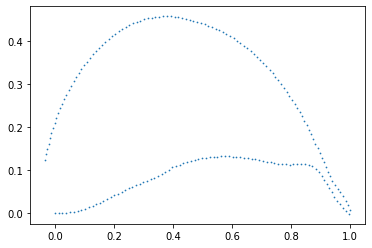

In [239]:
aa=190
plt.scatter(af_mesh.nodes[af_mesh.boundary_loops[1][:aa],0],af_mesh.nodes[af_mesh.boundary_loops[1][:aa],1],s=0.5)

In [142]:
# testing 
points0 = np.array([[0, 1, 8, 2, 2],
                   [1, 0, 6, 7, 2]]).T  # a (nbre_points x nbre_dim) array

points1 = np.array([[-1, 1, 18, 1, 1],
                   [1, -1, 12, 10, 3]]).T   # a (nbre_points x nbre_dim) array

# my_loop = loop(points, np.array([1,3]), ['a','b'], np.array([100,100]))
# my_loop.interpolation()

my_mesh = mesher_2d(points0, np.array([1,3]), ['a','b'], np.array([100,100]))
my_mesh.add_inner_loop(points1, np.array([1]), ['c'], np.array([300]))

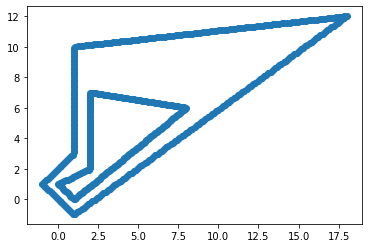

In [143]:
plt.scatter(my_mesh.pts[:,0],my_mesh.pts[:,1])

In [17]:
def mesh2poly(outline, holes=None, hole_pts=None, output_dir='./', scale=1):
    ## inputs:
    ## outline: outerbox boudnary, N*2 dimension, N means total number of points. 
    ## holes: [hole1, hole2,...] hole dimension M*2, M means total number of points of the hole's outline
    ## hole_pts: [hole_pt1, hole_pt2] dimension 2, xy coordinate of pt inside the hole
    ## output_dir: dir of the pslg file, current dir in default
    ## scale: scaling factor, default 1

    path = os.path.join(output_dir, "PSLG")
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

    def index_gen(n):
        return np.hstack((np.arange(n)[...,None],np.mod(np.arange(n)+1,n)[...,None]))
    
    if holes == None:
        print("internal flow")
        all_pts = outline
        segments = index_gen(len(outline))
        pts = all_pts*scale
        npts = len(pts)
        # starting to write file
        poly_file = open(os.path.join(path, "mesh.poly"), "w")
        poly_file.write("%d %d %d %d\n" % (npts, 2, 1, 0))
        for i in range(npts):
            poly_file.write("%d %f %f %f\n" % (i+1, pts[i,0], pts[i,1], 1.0))
        
        poly_file.write("%d %d\n" % (npts, 1) )
        id_loop= np.concatenate((np.arange(len(outline))+1,[1]))
        for i in range(len(outline)):
            poly_file.write("%d %d %d %d\n" % (i+1, id_loop[i],id_loop[i+1], 0))
        poly_file.write("%d\n" % 0)
        
    else:
        print("number of holes is:",len(holes))
        all_pts = holes.copy()
        all_pts.insert(0,outline)
        # print(holes)
        pts = np.vstack(all_pts)*scale
        hole_pts*=scale
        npts = len(pts)
        # calculate segments
        segments = []
        segments.append(index_gen(len(outline)))
        offset_id = len(outline)
        for i in range(len(holes)):
            segments.append(index_gen(len(holes[i]))+offset_id)
            offset_id += len(holes[i])
        segments = np.vstack(segments)
        
        
        # starting to write file
        poly_file = open(os.path.join(path, "mesh.poly"), "w")
        poly_file.write("%d %d %d %d\n" % (npts, 2, 1, 0))
        for i in range(npts):
            poly_file.write("%d %f %f %f\n" % (i+1, pts[i,0], pts[i,1], 1.0))
        
        poly_file.write("%d %d\n" % (npts, 1) )
        id_loop= np.concatenate((np.arange(len(outline))+1,[1]))
        for i in range(len(outline)):
            poly_file.write("%d %d %d %d\n" % (i+1, id_loop[i],id_loop[i+1], 0))
        
        # writing holes
        offset_id = len(outline)
        for ele in holes:
            id_loop= np.concatenate((np.arange(len(ele))+1,[1]))+offset_id
            for i in range(len(ele)):
                poly_file.write("%d %d %d %d\n" % (i+1+offset_id, id_loop[i],id_loop[i+1], 1))
            offset_id += len(ele)
        
        poly_file.write("%d\n" % len(holes))
        for i in range(len(hole_pts)):
            poly_file.write("%d %f %f\n" % (i+1, hole_pts[i][0], hole_pts[i][1]))
    return pts, segments

In [19]:
# load in info 
box = np.load('./airfoil/airfoil.npz')['arr_0']
af = np.load('./airfoil/airfoil.npz')['arr_1']
pslg = mesh2poly(box, [af], [np.array([0.5,0.3])], "./airfoil", scale=1)
tri = pymesh.triangle()
tri.points = pslg[0]
tri.segments = pslg[1]
tri.holes = np.array([[0.5,0.3]])
tri.max_area = 0.05;
tri.split_boundary = False;
tri.verbosity = 0;
tri.run()

number of holes is: 1


In [27]:
af_mesh = tri.mesh

In [168]:
# help(af_mesh)
af_mesh.nodes.shape # 77136,2
af_mesh.vertices.shape #  77136,2
af_mesh.boundary_edges.shape # 203,2
af_mesh.boundary_loops# 4,199
af_mesh.boundary_vertices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [32]:
pymesh.save_mesh("./airfoil/airfoil.stl", af_mesh);

In [35]:
meshio_mesh = meshio.read("./airfoil/airfoil.stl")

In [37]:
meshio_mesh.write("./airfoil/airfoil.su2")

In [38]:
su  = meshio.read("./airfoil/aorta_2d.su2")

    Surface tag  inlet will be replaced by 1
    Surface tag  topWall will be replaced by 2
    Surface tag  outlet will be replaced by 3
    Surface tag  bottomWall will be replaced by 4


In [69]:
su.cell_data['su2:tag'][0].shape

(3857,)

In [72]:
su.cells[0]

<meshio CellBlock, type: triangle, num cells: 3857>